# Notebook com resultados sistematizados

In [ ]:
# Importaçoẽs

import pickle
import numpy as np
import scipy
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline
cores = list(mcolors.TABLEAU_COLORS.keys())
cores = [cor.split(':')[-1] for cor in cores]

# sns.set_context('paper')

def plot_params():
    plt.rc('text', usetex=True)
    plt.rc('font', size=13)
    plt.rc('xtick', labelsize=11)
    plt.rc('ytick', labelsize=11)
    plt.rc('axes', labelsize=14)
    plt.rc('legend', fontsize=8)
    plt.rc('lines', linewidth=1.0)
    plt.rcParams["axes.formatter.limits"] = (-3, 4)
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plot_params()


from matplotlib.colors import LinearSegmentedColormap
colors = ["yellow","gold","lawngreen","royalblue", "midnightblue","royalblue","lawngreen","gold","yellow"]
nodes = np.linspace(0, 1, len(colors))
cmap_phase = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

colors1 = ["black","gold","lawngreen"]
nodes1 = np.linspace(0, 1, len(colors1))
cmap_potential = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes1, colors1)))

def get_numpy(data):
    """
    Converte os dados em formato de dicionário para matrizes NumPy.

    Args:
        data (dict): Dados no formato JSON armazenados em um tipo dicionário contendo informações sobre os valores de tensão de simulação.

    Returns:
        tuple: Uma tupla contendo um array NumPy representando os tempos e uma matriz NumPy representando os valores de tensão.
    """
    mapa = np.zeros((len(data['simData']['V_soma']), len(data['simData']['t'])))
    t = np.array(data['simData']['t'])
    for i, value in enumerate(data['simData']['V_soma'].values()):
        mapa[i] = value
    return t, mapa


## Baixo acoplamento:

In [ ]:
amp = []
gex = []
cv = []
mean_lop = []
mean_gop = []
spy_freq = []
tau_colapso = []
sync = []

def tau_c(gop, t_sample, trans):
    i = trans + 100
    try:
        while gop[i] < 0.9:
            t_colapso = t_sample[i]
            i+=1
        return t_colapso
    except:
        # IndexError
        t_colapso = t_sample[i-1]
        return t_colapso


for batch in range(1,49):
    for subbatch in range(0,3):
        b = 'batch'+str(batch).zfill(4)
        file = f'../data1/v1_{b}/v1_{b}_0_{subbatch}_data.pkl'
        with open(file, 'rb') as f:
            data = pickle.load(f)
        amp.append(data['simConfig']['IClamp0']['amp'])
        gex.append(data['simConfig']['gex'])
        mean_lop.append(data['LOP_delta'][5].mean(axis=0).mean())
        mean_gop.append(data['GOP'].mean())
        spy_freq.append(data['simData']['popRates']['sPY'])
        trans = data['simConfig']['desyncr_spikes_dur']*10
        t_c = tau_c(data['GOP'], data['t_phase'], trans)
        tau_colapso.append(t_c)

        b = 'batch'+str(batch).zfill(4)
        file = f'../data1/v1_{b}/v1_{b}_0_{subbatch}_CV.pkl'
        with open(file, 'rb') as f:
            data = pickle.load(f)
        cv.append(np.mean(data['statData'][0]))
        
        b = 'batch'+str(batch).zfill(4)
        file = f'../data1/v1_{b}/v1_{b}_0_{subbatch}_sync.pkl'
        with open(file, 'rb') as f:
            data = pickle.load(f)
        sync.append(data['statData'][0][0])
        del data


In [ ]:
gop_arr = np.array(np.array_split(mean_gop, 12))
lop_arr = np.array(np.array_split(mean_lop, 12))
cv_arr = np.array(np.array_split(cv, 12))
freq_arr = np.array(np.array_split(spy_freq, 12))
tau_colapso_arr = np.array(np.array_split(tau_colapso, 12))
sync_arr = np.array(np.array_split(sync, 12))


In [ ]:
axis_amp = sorted(set(amp))
axis_gex = sorted(set(gex))

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,6))
fig.set_tight_layout(20)
fig.suptitle('r= 0.14')
tg, ig = np.meshgrid(axis_amp, axis_gex)
hm0 = ax[0][0].pcolor(ig, tg, gop_arr, cmap='jet')
cbar0 = fig.colorbar(hm0, ax=ax[0][0])#, cax=cax1, format=formater)
cbar0.set_label(r'$\overline{GOP}$')

tg, ig = np.meshgrid(axis_amp, axis_gex)
hm1 = ax[0][1].pcolor(ig, tg, lop_arr, cmap='jet')
cbar1 = fig.colorbar(hm1, ax=ax[0][1])#, cax=cax1, format=formater)
cbar1.set_label(r'$\overline{LOP}$')

tg, ig = np.meshgrid(axis_amp, axis_gex)
hm2 = ax[1][0].pcolor(ig, tg, tau_colapso_arr, cmap='jet')
cbar2 = fig.colorbar(hm2, ax=ax[1][0])#, cax=cax1, format=formater)
cbar2.set_label(r'$\tau_c$ (ms)')

tg, ig = np.meshgrid(axis_amp, axis_gex)
hm3 = ax[1][1].pcolor(ig, tg, freq_arr, cmap='jet')
cbar3 = fig.colorbar(hm3, ax=ax[1][1])#, cax=cax1, format=formater)
cbar3.set_label('$\overline{Fr}$ (Hz)')

ax[0][0].set_ylabel('I(nA)')
ax[1][0].set_ylabel('I(nA)')
ax[1][0].set_xlabel('$g_{ex}$')
ax[1][1].set_xlabel('$g_{ex}$')
plt.savefig('../figures/Current_By_gex_means.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
raios = []
gex = []
cv = []
mean_lop = []
mean_gop = []
spy_freq = []
tau_colapso = []
sync = []

def tau_c(gop, t_sample, trans):
    i = trans+100
    try:
        while gop[i] < 0.9:
            t_colapso = t_sample[i]
            i+=1
        return t_colapso
    except:
        # IndexError
        t_colapso = t_sample[i-1]
        return t_colapso
    

for batch in range(1,49):
    for subbatch in range(0,3):
        b = 'batch'+str(batch).zfill(4)
        file = f'../data2/v2_{b}/v2_{b}_0_{subbatch}_data.pkl'
        with open(file, 'rb') as f:
            data = pickle.load(f)
        raios.append(data['r'])
        gex.append(data['simConfig']['gex'])
        mean_lop.append(data['LOP_delta'][5].mean(axis=0))
        mean_gop.append(data['GOP'].mean())
        spy_freq.append(data['simData']['popRates']['sPY'])
        trans = data['simConfig']['desyncr_spikes_dur']*10
        t_c = tau_c(data['GOP'], data['t_phase'], trans)
        tau_colapso.append(t_c)

        b = 'batch'+str(batch).zfill(4)
        file = f'../data2/v2_{b}/v2_{b}_0_{subbatch}_CV.pkl'
        with open(file, 'rb') as f:
            data = pickle.load(f)
        cv.append(np.mean(data['statData'][0]))
        
        b = 'batch'+str(batch).zfill(4)
        file = f'../data2/v2_{b}/v2_{b}_0_{subbatch}_sync.pkl'
        with open(file, 'rb') as f:
            data = pickle.load(f)
        sync.append(data['statData'][0][0])
        del data


In [ ]:
gop_arr = np.array(np.array_split(mean_gop, 12))
lop_arr = np.array(np.array_split(mean_lop, 12))
cv_arr = np.array(np.array_split(cv, 12))
freq_arr = np.array(np.array_split(spy_freq, 12))
tau_colapso_arr = np.array(np.array_split(tau_colapso, 12))
sync_arr = np.array(np.array_split(sync, 12))
axis_raios = sorted(set(raios))
axis_gex = sorted(set(gex))

In [ ]:

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,6))
fig.set_tight_layout(20)
fig.suptitle('amp = $0.85$ nA')
tg, ig = np.meshgrid(axis_raios, axis_gex)
hm0 = ax[0][0].pcolor(ig, tg, gop_arr, cmap='jet')
cbar0 = fig.colorbar(hm0, ax=ax[0][0])#, cax=cax1, format=formater)
cbar0.set_label(r'$\overline{GOP}$')

tg, ig = np.meshgrid(axis_raios, axis_gex)
hm1 = ax[0][1].pcolor(ig, tg, lop_arr, cmap='jet')
cbar1 = fig.colorbar(hm1, ax=ax[0][1])#, cax=cax1, format=formater)
cbar1.set_label(r'$\overline{LOP}$')

tg, ig = np.meshgrid(axis_raios, axis_gex)
hm2 = ax[1][0].pcolor(ig, tg, tau_colapso_arr, cmap='jet')
cbar2 = fig.colorbar(hm2, ax=ax[1][0])#, cax=cax1, format=formater)
cbar2.set_label(r'$\tau_c$ (ms)')

tg, ig = np.meshgrid(axis_raios, axis_gex)
hm3 = ax[1][1].pcolor(ig, tg, freq_arr, cmap='jet')
cbar3 = fig.colorbar(hm3, ax=ax[1][1])#, cax=cax1, format=formater)
cbar3.set_label('$Fr$ (Hz)')

ax[0][0].set_ylabel('r')
ax[1][0].set_ylabel('r')
ax[1][0].set_xlabel('$g_{ex}$')
ax[1][1].set_xlabel('$g_{ex}$')
plt.savefig('../figures/raio_By_gex_means.png', dpi=600, bbox_inches='tight')
plt.show()

# Alto acoplamento:

In [ ]:
# Importaçoẽs

import pickle
import numpy as np
import scipy
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline
cores = list(mcolors.TABLEAU_COLORS.keys())
cores = [cor.split(':')[-1] for cor in cores]

# sns.set_context('paper')

def plot_params():
    plt.rc('text', usetex=True)
    plt.rc('font', size=13)
    plt.rc('xtick', labelsize=11)
    plt.rc('ytick', labelsize=11)
    plt.rc('axes', labelsize=14)
    plt.rc('legend', fontsize=8)
    plt.rc('lines', linewidth=1.0)
    plt.rcParams["axes.formatter.limits"] = (-3, 4)
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plot_params()


from matplotlib.colors import LinearSegmentedColormap
colors = ["yellow","gold","lawngreen","royalblue", "midnightblue","royalblue","lawngreen","gold","yellow"]
nodes = np.linspace(0, 1, len(colors))
cmap_phase = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

colors1 = ["black","gold","lawngreen"]
nodes1 = np.linspace(0, 1, len(colors1))
cmap_potential = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes1, colors1)))

def get_numpy(data):
    """
    Converte os dados em formato de dicionário para matrizes NumPy.

    Args:
        data (dict): Dados no formato JSON armazenados em um tipo dicionário contendo informações sobre os valores de tensão de simulação.

    Returns:
        tuple: Uma tupla contendo um array NumPy representando os tempos e uma matriz NumPy representando os valores de tensão.
    """
    mapa = np.zeros((len(data['simData']['V_soma']), len(data['simData']['t'])))
    t = np.array(data['simData']['t'])
    for i, value in enumerate(data['simData']['V_soma'].values()):
        mapa[i] = value
    return t, mapa


In [ ]:
raios = []
gex = []
cv = []
mean_lop = []
mean_gop = []
spy_freq = []
tau_colapso = []
sync = []

def tau_c(gop, t_sample, trans):
    i = trans + 100
    try:
        while gop[i] < 0.9:
            t_colapso = t_sample[i]
            i+=1
        return t_colapso
    except:
        t_colapso = t_sample[i-1]
        pass
    return t_colapso

for batch in range(1,37):
    for subbatch in range(0,4):
        b = 'batch'+str(batch).zfill(4)
        file = f'../data/v3_{b}/v3_{b}_0_{subbatch}_data.pkl'
        with open(file, 'rb') as f:
            data = pickle.load(f)
        raios.append(data['r'])
        gex.append(data['simConfig']['gex'])
        mean_lop.append(data['LOP_delta'][5].mean())
        mean_gop.append(data['GOP'].mean())
        spy_freq.append(data['simData']['popRates']['sPY'])
        trans = data['simConfig']['desyncr_spikes_dur']*10
        t_c = tau_c(data['GOP'], data['t_phase'], trans)
        tau_colapso.append(t_c)

        b = 'batch'+str(batch).zfill(4)
        file = f'../data/v3_{b}/v3_{b}_0_{subbatch}_CV.pkl'
        with open(file, 'rb') as f:
            data = pickle.load(f)
        cv.append(np.mean(data['statData'][0]))
        
        b = 'batch'+str(batch).zfill(4)
        file = f'../data/v3_{b}/v3_{b}_0_{subbatch}_sync.pkl'
        with open(file, 'rb') as f:
            data = pickle.load(f)
        sync.append(data['statData'][0][0])
        del data


In [ ]:
gop_arr = np.array(np.array_split(mean_gop, 12))
lop_arr = np.array(np.array_split(mean_lop, 12))
cv_arr = np.array(np.array_split(cv, 12))
freq_arr = np.array(np.array_split(spy_freq, 12))
tau_colapso_arr = np.array(np.array_split(tau_colapso, 12))
sync_arr = np.array(np.array_split(sync, 12))
axis_raios = sorted(set(raios))
axis_gex = sorted(set(gex))

In [ ]:
raios[:12]

In [ ]:
axis_raios[1]

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,7.5))
fig.set_tight_layout(20)
fig.suptitle('amp = $0.8$ nA')
for ax0 in ax:
    for ax1 in ax0:
        ax1.set_xlim(axis_gex[0]-5e-4, axis_gex[-1]+4e-4)
        # ax1.set_ylim(axis_raios[0]-1e-2, axis_raios[-1]+1e-2)
        ax1.set_yticks(axis_raios)
        ax1.set_xticks(axis_gex)
        ax1.set_xticklabels(axis_gex, rotation=60)

tg, ig = np.meshgrid(axis_raios, axis_gex)
hm0 = ax[0][0].pcolor(ig, tg, gop_arr, cmap='jet')
cbar0 = fig.colorbar(hm0, ax=ax[0][0])#, cax=cax1, format=formater)
cbar0.set_label(r'$\overline{GOP}$')



tg, ig = np.meshgrid(axis_raios, axis_gex)
hm1 = ax[0][1].pcolor(ig, tg, lop_arr, cmap='jet')
cbar1 = fig.colorbar(hm1, ax=ax[0][1])#, cax=cax1, format=formater)
cbar1.set_label(r'$\overline{LOP}$')

tg, ig = np.meshgrid(axis_raios, axis_gex)
hm2 = ax[1][0].pcolor(ig, tg, tau_colapso_arr, cmap='jet')
cbar2 = fig.colorbar(hm2, ax=ax[1][0])#, cax=cax1, format=formater)
cbar2.set_label(r'$\tau_c$ (ms)')

tg, ig = np.meshgrid(axis_raios, axis_gex)
hm3 = ax[1][1].pcolor(ig, tg, freq_arr, cmap='jet')
cbar3 = fig.colorbar(hm3, ax=ax[1][1])#, cax=cax1, format=formater)
cbar3.set_label('$Fr$ (Hz)')

ax[0][0].set_title('Parâmetro Ordem Global')
ax[0][1].set_title('Parâmetro Ordem Local')
ax[1][0].set_title('Tempo colapso')
ax[1][1].set_title('Frequência sPY')

ax[0][0].set_ylabel('r')
ax[1][0].set_ylabel('r')
ax[1][0].set_xlabel('$g_{ex}$')
ax[1][1].set_xlabel('$g_{ex}$')
# plt.savefig('../figures/raio_By_gex_means_highcoupling.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
axis_gex

# Analises região de interesse

#### Data 1: Raio fixo $r=0.22$, $g_{ex} = 0.0014$

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
colors = ["darkorange", "gold", "lawngreen", "lightseagreen","darkgreen"]
cmap_LOP = ListedColormap(colors)


In [ ]:
def plot_Hist_LOP(LOP):
    lop = LOP.mean(axis=1)
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,4), gridspec_kw={'width_ratios':[1,3]})
    fig.set_tight_layout(20)
    # fig.suptitle('$g_{ex}='+f'{gex}$ S/cm²'+'$I='+f'{amp}$ nA'+f' $r$: {float(r)}')
    for axis in ax:
        axis.spines['top'].set_visible(False)
        axis.spines['right'].set_visible(False)

    ax[0].set_title('Box Plot', fontsize=10)
    bp = ax[0].boxplot(
        lop[1000:-100],positions=[0.42], showmeans=True, showfliers=False,
        medianprops = dict(linewidth=1.5),
        )
    ax[0].set_xlim(0,.5)
    ax[0].set_ylim(-0.05, 1.05)
    ax[0].legend([bp['medians'][0], bp['means'][0]], ['Mediana', 'Média'], loc='upper left')
    ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].xaxis.set_visible(False)
    ax[0].set_yticks([])
    ax[0].set_ylim(-0.05, 1.05) 
    ax[0].set_ylabel('LOP(t)')
    

    ax[1].set_xlabel('Frequência do LOP(t)')
    hist = ax[1].hist(lop[1000:-100], color='orange', orientation='horizontal',edgecolor='black', linewidth=1.2)
    ax[1].set_ylim(-0.05, 1.05)
    ax[1].annotate(f'bins: {10}', xy=(hist[0][-1],0))
    # plt.savefig(file+f'_HistBoxlop_{gex}_{amp}.png', dpi=600, bbox_inches='tight')

In [ ]:
def plotAll(data, ti, tf):
    spatial_phi = data['phases'][:,ti*10:tf*10]
    t_phase_smp = data['t_phase'][ti*10:tf*10]
    gop = data['GOP'][ti*10:tf*10]
    lop = data['LOP_delta'][5][ti*10:tf*10, :]
    delta = 5
    n = 1,
    gex = data['simConfig']['gex'],
    amp = data['simConfig']['IClamp0']['amp'],
    r = data['r']

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, figsize=(6,6))
    fig.set_tight_layout(20)
    fig.suptitle('$g_{ex}='+f'{gex}$ S/cm²' + ' | '+'$I='+f'{amp}$ nA'+ ' | '+ f'$r$: {float(r)}', fontsize=14)

    # Phases
    ax1.set_title('Fase dos $n$ neurônios', pad=20)
    n_neurons = np.arange(spatial_phi.shape[0])
    t = t_phase_smp
    tg, ig = np.meshgrid(n_neurons, t)
    hm1 = ax1.pcolor(ig, tg, spatial_phi.T, cmap=cmap_phase, vmax=2*np.pi)
    
    cbar1 = fig.colorbar(hm1, ax=ax1, ticks=[0, np.pi, 2*np.pi])#, cax=cax1, format=formater)
    cbar1.set_label('$\phi(t)$')
    ax1.set_ylim(0,len(n_neurons))
    cbar1.ax.set_yticklabels(['0', '$\pi$', '$2 \pi$']) 
    ax1.set_ylabel('$n$ neurônio')
    ax1.set_xlabel('Tempo (ms)')

    #LOP
    ax2.set_title('Série temporal do LOP(t),'+'$\delta='+f'{delta}'+'$', pad=20)
    n_neurons = np.arange(lop.shape[1])
    t = t_phase_smp
    tg, ig = np.meshgrid(n_neurons, t)
    hm2 = ax2.pcolor(ig, tg, lop, cmap=cmap_LOP, vmax=1.0, vmin=0)#cmap_LOP)

    cbar2= plt.colorbar(hm2, ax=ax2, ticks=[0, 1])
    cbar2.ax.set_yticklabels(['0', '1,0']) 
    cbar2.set_label('LOP$(t)$')
    ax2.set_ylabel('$n$ neurônio')
    ax2.set_ylim(0,len(n_neurons))
    ax2.set_xlabel('Tempo (ms)')

    # GOP
    ax3.set_title('Série temporal do GOP(t)', pad=20)
    ax3.plot(t_phase_smp, gop, color='darkred')
    ax3.set_xlabel('Tempo (ms)')
    ax3.set_ylim(-0.05, 1.05)
    ax3.set_xlim(t_phase_smp[0], t_phase_smp[-1])
    ax3.set_ylabel('GOP$(t)$')
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    plt.show()


In [ ]:
def plotPotencial(data,n1,n2, ti=20000, tf=30000):
    voltage0 = np.array(data['simData']['V_soma'][f'cell_{n1}'][ti:tf])
    voltage1 = np.array(data['simData']['V_soma'][f'cell_{n2}'][ti:tf])
    time = np.array(data['simData']['t'][ti:tf])
    f, ax0 = plt.subplots(1,1, figsize=(10,3))
    sns.lineplot(x = time, y =voltage0, color='black', ax=ax0)
    sns.lineplot(x = time, y =voltage1, color='red', ax=ax0)
    ax0.set_ylabel('Voltage (mV)')
    ax0.spines['right'].set_visible(False)
    ax0.spines['top'].set_visible(False)
    ax0.set_xlabel('t (ms)')
    plt.tight_layout()

In [ ]:
plotAll(data51)

In [ ]:
plotAll(data52)

In [ ]:
std51 = data51['LOP_delta'][5][49000:50000, :].mean(axis=1).std()
std51

In [ ]:
std52 = data52['LOP_delta'][5][49000:50000, :].mean(axis=1).std()
std52

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,2))

# sns.histplot(data51['LOP_delta'][5][49000:50000, :].std(axis=1), stat='percent',ax=ax)
# sns.histplot(data52['LOP_delta'][5][49000:50000, :].std(axis=1), stat='percent',ax=ax)

ax[0].hist(data51['LOP_delta'][5][49000:50000, :].std(axis=1), color='orange', edgecolor='black', linewidth=1.2, bins=10)
ax[1].hist(data52['LOP_delta'][5][49000:50000, :].std(axis=1), color='orange', edgecolor='black', linewidth=1.2, bins=10)
ax[0].set_xlim(0.17,0.18)
ax[1].set_xlim(0.0,0.02)

ax[1].set_title('Desvio padrão do $\overline{LOP}$\nda rede com linhas diagonais')
ax[0].set_title('Desvio padrão do $\overline{LOP}$\nda rede com padrão "xadrez"')

for axis in ax:
    axis.set_xlabel('$\sigma(\overline{LOP})$')
plt.legend()

In [ ]:
plotAll(data81)

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,2))

ax.hist(data81['LOP_delta'][5][49000:50000, :].std(axis=1), color='orange',
         edgecolor='black', linewidth=1.2)
ax.set_title('Desvio padrão do $\overline{LOP}$\nda rede com padrão "diagonal"')
ax.set_xlabel('$\sigma(\overline{LOP})$')
# plt.legend()

In [ ]:
plotAll(data82)

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,2))

ax.hist(data82['LOP_delta'][5][49000:50000, :].std(axis=1), color='orange',
         edgecolor='black', linewidth=1.2)
ax.set_title('Desvio padrão do $\overline{LOP}$\nda rede com padrão "diagonal"')
ax.set_xlabel('$\sigma(\overline{LOP})$')
# plt.legend()

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,2))

ax.hist(data83['LOP_delta'][5][49500:50000, :].std(axis=1), color='orange',
         edgecolor='black', linewidth=1.2)
ax.set_title('Desvio padrão do $\overline{LOP}$\nda rede com padrão "diagonal"')
ax.set_xlabel('$\sigma(\overline{LOP})$')
# plt.legend()

In [ ]:
plotAll(data0)

In [ ]:
gops = {}
lops = {}
amps = []
raios = []
for i in range(4,50,4):
    bn = str(i).zfill(2)
    with open(f'../data1/v1_batch00{bn}/v1_batch00{bn}_0_0_data.pkl', 'rb') as f:
        data = pickle.load(f)
    gops[data['simConfig']['gex']] = data['GOP']
    lops[data['simConfig']['gex']] = data['LOP_delta'][5].mean(axis=1)
    amps.append(data['simConfig']['IClamp0']['amp'])
    raios.append(data['r'])
    # plotRaster(t_phase_smp=data['t_phase'], t_peaks=data['t_peaks'],
    #            n = i, gex =data['simConfig']['gex'], amp = data['simConfig']['IClamp0']['amp'], r=data['r'])
    del data

In [ ]:
list(range(3,50,4))

In [ ]:
list(range(3,50,4))

In [ ]:
colors = ['b', 'g','r','c','m','y', 'tab:blue','tab:orange','tab:green', 'tab:red','tab:purple','tab:brown','tab:pink']

In [ ]:
print(amps)
print(raios)

# V4

In [1]:
# Importaçoẽs

import pickle
import numpy as np
import scipy
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
%matplotlib inline
cores = list(mcolors.TABLEAU_COLORS.keys())
cores = [cor.split(':')[-1] for cor in cores]

# sns.set_context('paper')

def plot_params():
    plt.rc('text', usetex=True)
    plt.rc('font', size=13)
    plt.rc('xtick', labelsize=11)
    plt.rc('ytick', labelsize=11)
    plt.rc('axes', labelsize=14)
    plt.rc('legend', fontsize=8)
    plt.rc('lines', linewidth=1.0)
    plt.rcParams["axes.formatter.limits"] = (-3, 4)
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plot_params()


from matplotlib.colors import LinearSegmentedColormap
colors = ["yellow","gold","lawngreen","royalblue", "midnightblue","royalblue","lawngreen","gold","yellow"]
nodes = np.linspace(0, 1, len(colors))
cmap_phase = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

colors1 = ["black","gold","lawngreen"]
nodes1 = np.linspace(0, 1, len(colors1))
cmap_potential = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes1, colors1)))

colors = ["darkorange", "gold", "lawngreen", "lightseagreen","darkgreen"]
cmap_LOP = ListedColormap(colors)

colors = ["darkblue", "blue", "lawngreen","red"]
nodes = [0.0, 0.1, 0.3, 1.0]
cmap_Freq = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))


def get_numpy(data, ti, tf):
    """
    Converte os dados em formato de dicionário para matrizes NumPy.

    Args:
        data (dict): Dados no formato JSON armazenados em um tipo dicionário contendo informações sobre os valores de tensão de simulação.

    Returns:
        tuple: Uma tupla contendo um array NumPy representando os tempos e uma matriz NumPy representando os valores de tensão.
    """
    ti = int(data['t_phase'][ti]*10)
    tf = int(data['t_phase'][tf]*10)
    mapa = np.zeros((len(data['simData']['V_soma']), len(data['simData']['t'][ti:tf])))
    t = np.array(data['simData']['t'][ti:tf])
    for i, value in enumerate(data['simData']['V_soma'].values()):
        mapa[i] = value[ti:tf]
    return t, mapa

def time_to_coherence(gop, t, gop_threshold = 0.90, percent_threshold=0.8):
    """
    Calcula o tempo necessário para atingir uma coerência específica.

    Esta função recebe duas listas, 'gop' e 't', representando as métricas de GOP (Global Order Parameter)
    e os tempos correspondentes, respectivamente.

    A função calcula a porcentagem de valores de GOP acima do limite 'gop_threshold'
    até que essa porcentagem alcance o limite 'percent_threshold'. Quando essa condição é
    satisfeita, o tempo correspondente é considerado o tempo de coerência (t_coherence).

    Args:
        gop (list[float]): Uma lista de valores de métricas de GOP.
        t (list[float]): Uma lista de tempos correspondentes às métricas de GOP.
        gop_threshold (float, optional): Limite de métricas de GOP para considerar como "coerentes".
                                         Padrão é 0.85.
        percent_threshold (float, optional): Limite de porcentagem para considerar que a coerência foi atingida.
                                             Padrão é 0.8.

    Returns:
        tuple: Uma tupla contendo o tempo necessário para atingir a coerência desejada e a lista
               de porcentagens de valores de GOP acima do limite em cada etapa de cálculo.

    Raises:
        None

    Example:
        gop = [0.87, 0.92, 0.95, 0.91, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
        t = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
        coherence_time = time_to_coherence(gop, t)
        print(coherence_time)  # Saída esperada: 1.0

        gop = [0.87, 0.92, 0.95, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91]
        t = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
        coherence_time = time_to_coherence(gop, t)
        print(coherence_time)  # Saída esperada: 0.5
    """
    percent, counter, i, t_coherence = 0, 0, 0, 0
    percents = []

    try:
        while percent < percent_threshold:
            if gop[i] > gop_threshold:
                counter += 1
            percent = counter / len(gop[:i+1])
            percents.append(percent)
            if percent >= percent_threshold:
                t_coherence = t[i]
            i += 1
    except (ValueError, IndexError):
        t_coherence = t[i - 1]

    return t_coherence, percents


def t_convergencia_gop(gop, t_sample, std_thresholds, win=10000):
    """
    Calcula o tempo de convergência com base na dispersão do parâmetro GOP (Global Order Parameter).

    Esta função recebe um array 'gop', onde cada elemento representa o valor de GOP,
    e um array 't_sample', que contém os tempos correspondentes às séries temporais de GOP.

    A função calcula o tempo em que a dispersão móvel do GOP atinge um limiar 'std_thresholds' após
    uma janela de 'win' pontos consecutivos. Esse tempo é considerado o tempo de convergência.

    Args:
        gop (numpy.ndarray): Um array de parâmetros GOP.
        t_sample (numpy.ndarray): Um array de tempos correspondentes às séries temporais de GOP.
        win (int, optional): O tamanho da janela deslizante para o cálculo da dispersão. Padrão é 10000.
        std_thresholds (list of float): Uma lista de limiares de dispersão para determinar a convergência.

    Returns:
        tuple (numpy.ndarray, numpy.ndarray): Uma tupla contendo um array NumPy com os tempos de convergência para cada limiar
        e um array NumPy contendo as dispersões calculadas para cada janela.

    Raises:
        None
    """

    std = np.zeros(len(gop) - win)
    t_coherences = np.zeros(len(std_thresholds))
    i = 0

    try:
        gates = np.full(len(std_thresholds), True) # gates of threholds 
        while np.std(gop[i:i+win]) > np.min(std_thresholds):
            std[i] = np.std(gop[i:i+win])
            for g, (n, threshold) in zip(gates , enumerate(std_thresholds)):
                if g and std[i] < threshold:
                    t_coherences[n] = t_sample[i]
                    gates[n] = False 
            i += 1

        for n, g in enumerate(gates):
            if g:
                t_coherences[n] = t_sample[i]
        return t_coherences, std
    except (ValueError, IndexError):
        for n, g in enumerate(gates):
            if g:
                t_coherences[n] = t_sample[i-1]
            else:
                t_coherences[n] = t_coherences[n]
        return t_coherences, std
    
def t_convergencia_lop(lop, t_sample, std_thresholds, win=10000):
    """
    Calcula o tempo de convergência com base na dispersão do parâmetro LOP (Local Order Parameter).

    Esta função recebe um array 'lop', onde cada elemento representa o valor de LOP de cada elemento,
    e um array 't_sample', que contém os tempos correspondentes às séries temporais de LOP.

    A função calcula o tempo em que a dispersão móvel do LOP espacial médio atinge um limiar 'std_thresholds' após
    uma janela de 'win' pontos consecutivos. Esse tempo é considerado o tempo de convergência.

    Args:
        lop (numpy.ndarray): Um array de parâmetros LOP.
        t_sample (numpy.ndarray): Um array de tempos correspondentes às séries temporais de GOP.
        win (int, optional): O tamanho da janela deslizante para o cálculo da dispersão. Padrão é 10000.
        std_thresholds (list of float): Uma lista de limiares de dispersão para determinar a convergência.

    Returns:
        tuple (numpy.ndarray, numpy.ndarray): Uma tupla contendo um array NumPy com os tempos de convergência para cada limiar
        e um array NumPy contendo as dispersões calculadas para cada janela.

    Raises:
        None
    """

    lop_mean = lop.mean(axis=1)
    std = np.zeros(len(lop_mean) - win)
    t_coherences = np.zeros(len(std_thresholds))
    i = 0

    try:
        gates = np.full(len(std_thresholds), True) # gates of threholds 
        while np.std(lop_mean[i:i+win]) > np.min(std_thresholds):
            std[i] = np.std(lop_mean[i:i+win])
            for g, (n, threshold) in zip(gates , enumerate(std_thresholds)):
                if g and std[i] < threshold:
                    t_coherences[n] = t_sample[i]
                    gates[n] = False 
            i += 1

        for n, g in enumerate(gates):
            if g:
                t_coherences[n] = t_sample[i]
        return t_coherences, std
    except (ValueError, IndexError):
        for n, g in enumerate(gates):
            if g:
                t_coherences[n] = t_sample[i-1]
            else:
                t_coherences[n] = t_coherences[n]
        return t_coherences, std

In [2]:
amp = []
gex = []
raios = []
cv = []
mean_lop = []
mean_gop = []
spy_freq = []
tau_colapso = []
tau_conv_lop = []
tau_conv_gop = []
percent_coherence = []
sync = []
std_thresholds = [0.1]

for batch in range(1,65):
    for subbatch in range(0,4):
        b = 'batch'+str(batch).zfill(4)
        file = f'../data4/v4_{b}/v4_{b}_0_{subbatch}_data.pkl'
        with open(file, 'rb') as f:
            data = pickle.load(f)
        raios.append(data['r'])
        amp.append(data['simConfig']['IClamp0']['amp'])
        gex.append(data['simConfig']['gex'])
        mean_lop.append(data['LOP_delta'][5].mean(axis=1)[-10000:].mean())
        mean_gop.append(data['GOP'][-10000:].mean())
        spy_freq.append(data['simData']['popRates']['sPY'])
        trans = data['simConfig']['desyncr_spikes_dur']*10
        t_c = data['tempo_para_coerencia'][0]
        tau_colapso.append(t_c)
        percent = np.mean(data['tempo_para_coerencia'][1])
        percent_coherence.append(np.mean(percent))

        t_conv_lop, _ = t_convergencia_lop(data['LOP_delta'][5], data['t_phase'], std_thresholds)
        t_conv_gop, _ = t_convergencia_gop(data['GOP'], data['t_phase'], std_thresholds)

        tau_conv_lop.append(t_conv_lop[0])
        tau_conv_gop.append(t_conv_gop[0])

        b = 'batch'+str(batch).zfill(4)
        file = f'../data4/v4_{b}/v4_{b}_0_{subbatch}_CV.pkl'
        with open(file, 'rb') as f:
            data = pickle.load(f)
        cv.append(np.mean(data['statData'][0]))
        
        b = 'batch'+str(batch).zfill(4)
        file = f'../data4/v4_{b}/v4_{b}_0_{subbatch}_sync.pkl'
        with open(file, 'rb') as f:
            data = pickle.load(f)
        sync.append(data['statData'][0][0])
        del data


In [3]:
gop_arr = np.array(np.array_split(mean_gop, 16))
lop_arr = np.array(np.array_split(mean_lop, 16))
cv_arr = np.array(np.array_split(cv, 16))
freq_arr = np.array(np.array_split(spy_freq, 16))
tau_colapso_arr = np.array(np.array_split(tau_colapso, 16))
tau_conv_lop_arr = np.array(np.array_split(tau_conv_lop, 16))
tau_conv_gop_arr = np.array(np.array_split(tau_conv_gop, 16))
percent_coherence_arr = np.array(np.array_split(percent_coherence, 16))
sync_arr = np.array(np.array_split(sync, 16))


In [4]:
axis_amp = np.array(sorted(set(amp)))
axis_raios = np.array(sorted(set(raios)))
axis_gex = np.array(sorted(set(gex)))
axis_raios.shape

(16,)

In [5]:
data = {
    'gop_arr':gop_arr,
    'lop_arr':lop_arr,
    'cv_arr':cv_arr,
    'freq_arr':freq_arr,
    'tau_colapso_arr':tau_colapso_arr,
    'tau_conv_lop_arr':tau_conv_lop_arr,
    'tau_conv_gop_arr':tau_conv_gop_arr,
    'percent_coherence_arr':percent_coherence_arr,
    'sync_arr':sync_arr,
    'axis_amp':axis_amp,
    'axis_raios':axis_raios,
    'axis_gex':axis_gex,
}

with open('../pickle_files/v4_high_coupling_data.pkl', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
with open('../pickle_files/v4_high_coupling_data.pkl', 'rb') as f:
    data_space_param = pickle.load(f)

gop_arr = data_space_param['gop_arr']
lop_arr = data_space_param['lop_arr']
cv_arr = data_space_param['cv_arr']
freq_arr = data_space_param['freq_arr']
tau_colapso_arr = data_space_param['tau_colapso_arr']
tau_conv_lop_arr = data_space_param['tau_conv_lop_arr']
tau_conv_gop_arr = data_space_param['tau_conv_gop_arr']
percent_coherence_arr = data_space_param['percent_coherence_arr']
sync_arr = data_space_param['sync_arr']
axis_amp = data_space_param['axis_amp']
axis_raios = data_space_param['axis_raios']
axis_gex = data_space_param['axis_gex']

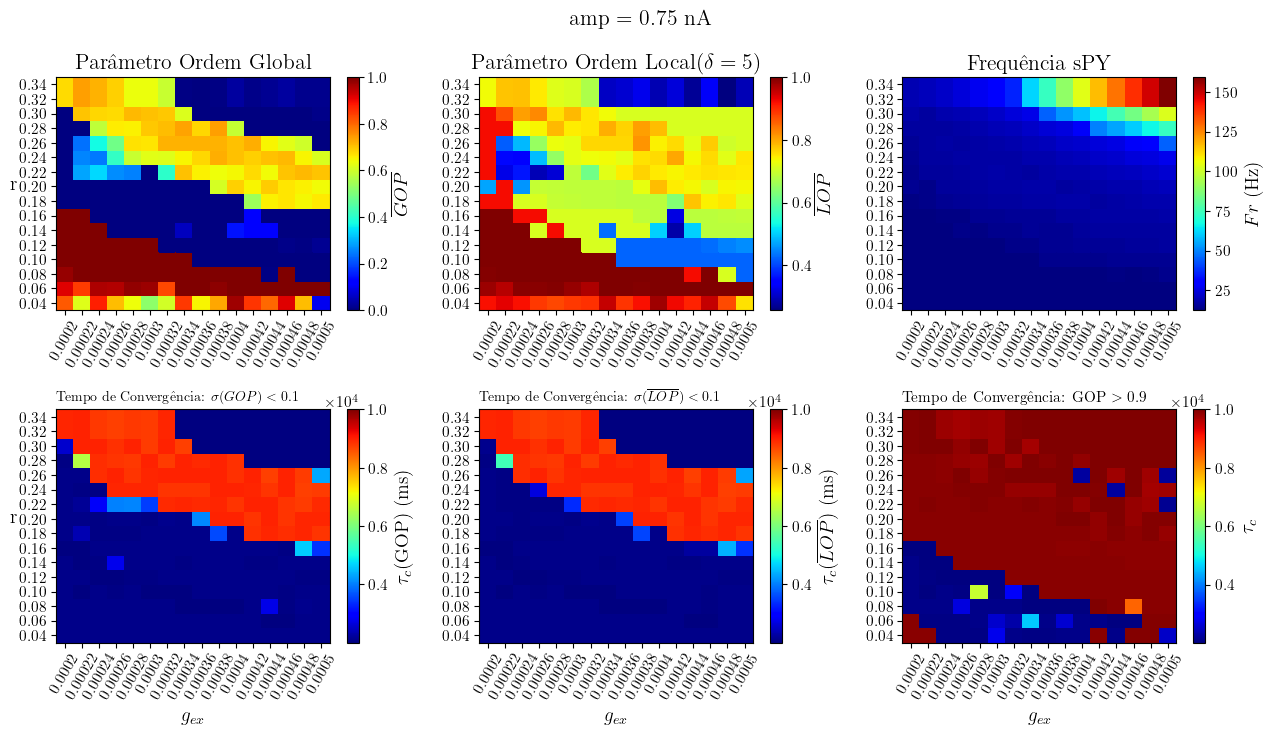

In [7]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(13,7.5))
fig.set_tight_layout(20)
i_inj = f'${axis_amp[0]}$'
fig.suptitle(f'amp = {i_inj} nA')
for ax0 in ax:
    for ax1 in ax0:
        # ax1.set_xlim(axis_gex[0]-5e-4, axis_gex[-1]+4e-4)
        # ax1.set_ylim(axis_raios[0]-1e-2, axis_raios[-1]+1e-2)
        ax1.set_yticks(axis_raios)
        ax1.set_xticks(axis_gex)
        ax1.set_xticklabels(axis_gex, rotation=60)

tg, ig = np.meshgrid(axis_raios, axis_gex)
hm0 = ax[0][0].pcolor(ig, tg, gop_arr, cmap='jet')
cbar0 = fig.colorbar(hm0, ax=ax[0][0])#, cax=cax1, format=formater)
cbar0.set_label(r'$\overline{GOP}$')

tg, ig = np.meshgrid(axis_raios, axis_gex)
hm1 = ax[0][1].pcolor(ig, tg, lop_arr, cmap='jet')
cbar1 = fig.colorbar(hm1, ax=ax[0][1])#, cax=cax1, format=formater)
cbar1.set_label(r'$\overline{LOP}$')

tg, ig = np.meshgrid(axis_raios, axis_gex)
hm3 = ax[0][2].pcolor(ig, tg, freq_arr, cmap='jet')
cbar3 = fig.colorbar(hm3, ax=ax[0][2])#, cax=cax1, format=formater)
cbar3.set_label('$Fr$ (Hz)')

tg, ig = np.meshgrid(axis_raios, axis_gex)
hm2 = ax[1][0].pcolor(ig, tg, tau_conv_gop_arr, cmap='jet', vmax=10000)
cbar2 = fig.colorbar(hm2, ax=ax[1][0])#, cax=cax1, format=formater)
cbar2.set_label(r'$\tau_c$(GOP) (ms)')

tg, ig = np.meshgrid(axis_raios, axis_gex)
hm2 = ax[1][1].pcolor(ig, tg, tau_conv_lop_arr, cmap='jet', vmax=10000)
cbar2 = fig.colorbar(hm2, ax=ax[1][1])#, cax=cax1, format=formater)
cbar2.set_label(r'$\tau_c(\overline{LOP})$ (ms)')

tg, ig = np.meshgrid(axis_raios, axis_gex)
hm3 = ax[1][2].pcolor(ig, tg, tau_colapso_arr, cmap='jet', vmax=10000)
cbar3 = fig.colorbar(hm3, ax=ax[1][2])#, cax=cax1, format=formater)
cbar3.set_label(r'$\tau_c$')


label_tconvergencia_lop = r'$\sigma(\overline{LOP}) <'+f'{std_thresholds[0]}'+'$'
label_tconvergencia_gop = r'$\sigma(GOP) < '+f'{std_thresholds[0]}'+'$'
label_tconvergencia = r' GOP $ > 0.9 $'
ax[0][0].set_title('Parâmetro Ordem Global')
ax[0][1].set_title('Parâmetro Ordem Local($\delta = 5$)')
ax[0][2].set_title('Frequência sPY')
ax[1][0].set_title('Tempo de Convergência: '+label_tconvergencia_gop, fontsize=10, loc='left')
ax[1][1].set_title('Tempo de Convergência: '+label_tconvergencia_lop, fontsize=10, loc='left')
ax[1][2].set_title('Tempo de Convergência: ' + label_tconvergencia, fontsize=11, loc='left')

ax[0][0].set_ylabel('r ', rotation=0)
ax[1][0].set_ylabel('r ', rotation=0)
ax[1][0].set_xlabel('$g_{ex}$')
ax[1][1].set_xlabel('$g_{ex}$')
ax[1][2].set_xlabel('$g_{ex}$')
# plt.savefig('../figures2/raio_By_gex_means_highcoupling.png', dpi=600, bbox_inches='tight')
plt.show()

## Threholds tempos de convergência

In [1]:
# Importaçoẽs

import pickle
import numpy as np
import scipy
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
%matplotlib inline
cores = list(mcolors.TABLEAU_COLORS.keys())
cores = [cor.split(':')[-1] for cor in cores]

# sns.set_context('paper')

def plot_params():
    plt.rc('text', usetex=True)
    plt.rc('font', size=13)
    plt.rc('xtick', labelsize=11)
    plt.rc('ytick', labelsize=11)
    plt.rc('axes', labelsize=14)
    plt.rc('legend', fontsize=8)
    plt.rc('lines', linewidth=1.0)
    plt.rcParams["axes.formatter.limits"] = (-3, 4)
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plot_params()


from matplotlib.colors import LinearSegmentedColormap
colors = ["yellow","gold","lawngreen","royalblue", "midnightblue","royalblue","lawngreen","gold","yellow"]
nodes = np.linspace(0, 1, len(colors))
cmap_phase = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

colors1 = ["black","gold","lawngreen"]
nodes1 = np.linspace(0, 1, len(colors1))
cmap_potential = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes1, colors1)))

colors = ["darkorange", "gold", "lawngreen", "lightseagreen","darkgreen"]
cmap_LOP = ListedColormap(colors)

colors = ["darkblue", "blue", "lawngreen","red"]
nodes = [0.0, 0.1, 0.3, 1.0]
cmap_Freq = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))


def get_numpy(data, ti, tf):
    """
    Converte os dados em formato de dicionário para matrizes NumPy.

    Args:
        data (dict): Dados no formato JSON armazenados em um tipo dicionário contendo informações sobre os valores de tensão de simulação.

    Returns:
        tuple: Uma tupla contendo um array NumPy representando os tempos e uma matriz NumPy representando os valores de tensão.
    """
    ti = int(data['t_phase'][ti]*10)
    tf = int(data['t_phase'][tf]*10)
    mapa = np.zeros((len(data['simData']['V_soma']), len(data['simData']['t'][ti:tf])))
    t = np.array(data['simData']['t'][ti:tf])
    for i, value in enumerate(data['simData']['V_soma'].values()):
        mapa[i] = value[ti:tf]
    return t, mapa

def time_to_coherence(gop, t, gop_threshold = 0.90, percent_threshold=0.8):
    """
    Calcula o tempo necessário para atingir uma coerência específica.

    Esta função recebe duas listas, 'gop' e 't', representando as métricas de GOP (Global Order Parameter)
    e os tempos correspondentes, respectivamente.

    A função calcula a porcentagem de valores de GOP acima do limite 'gop_threshold'
    até que essa porcentagem alcance o limite 'percent_threshold'. Quando essa condição é
    satisfeita, o tempo correspondente é considerado o tempo de coerência (t_coherence).

    Args:
        gop (list[float]): Uma lista de valores de métricas de GOP.
        t (list[float]): Uma lista de tempos correspondentes às métricas de GOP.
        gop_threshold (float, optional): Limite de métricas de GOP para considerar como "coerentes".
                                         Padrão é 0.85.
        percent_threshold (float, optional): Limite de porcentagem para considerar que a coerência foi atingida.
                                             Padrão é 0.8.

    Returns:
        tuple: Uma tupla contendo o tempo necessário para atingir a coerência desejada e a lista
               de porcentagens de valores de GOP acima do limite em cada etapa de cálculo.

    Raises:
        None

    Example:
        gop = [0.87, 0.92, 0.95, 0.91, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
        t = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
        coherence_time = time_to_coherence(gop, t)
        print(coherence_time)  # Saída esperada: 1.0

        gop = [0.87, 0.92, 0.95, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91]
        t = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
        coherence_time = time_to_coherence(gop, t)
        print(coherence_time)  # Saída esperada: 0.5
    """
    percent, counter, i, t_coherence = 0, 0, 0, 0
    percents = []

    try:
        while percent < percent_threshold:
            if gop[i] > gop_threshold:
                counter += 1
            percent = counter / len(gop[:i+1])
            percents.append(percent)
            if percent >= percent_threshold:
                t_coherence = t[i]
            i += 1
    except (ValueError, IndexError):
        t_coherence = t[i - 1]

    return t_coherence, percents


def t_convergencia_gop(gop, t_sample, std_thresholds, win=10000):
    """
    Calcula o tempo de convergência com base na dispersão do parâmetro GOP (Global Order Parameter).

    Esta função recebe um array 'gop', onde cada elemento representa o valor de GOP,
    e um array 't_sample', que contém os tempos correspondentes às séries temporais de GOP.

    A função calcula o tempo em que a dispersão móvel do GOP atinge um limiar 'std_thresholds' após
    uma janela de 'win' pontos consecutivos. Esse tempo é considerado o tempo de convergência.

    Args:
        gop (numpy.ndarray): Um array de parâmetros GOP.
        t_sample (numpy.ndarray): Um array de tempos correspondentes às séries temporais de GOP.
        win (int, optional): O tamanho da janela deslizante para o cálculo da dispersão. Padrão é 10000.
        std_thresholds (list of float): Uma lista de limiares de dispersão para determinar a convergência.

    Returns:
        tuple (numpy.ndarray, numpy.ndarray): Uma tupla contendo um array NumPy com os tempos de convergência para cada limiar
        e um array NumPy contendo as dispersões calculadas para cada janela.

    Raises:
        None
    """

    std = np.zeros(len(gop) - win)
    t_coherences = np.zeros(len(std_thresholds))
    i = 0

    try:
        gates = np.full(len(std_thresholds), True) # gates of threholds 
        while np.std(gop[i:i+win]) > np.min(std_thresholds):
            std[i] = np.std(gop[i:i+win])
            for g, (n, threshold) in zip(gates , enumerate(std_thresholds)):
                if g and std[i] < threshold:
                    t_coherences[n] = t_sample[i]
                    gates[n] = False 
            i += 1

        for n, g in enumerate(gates):
            if g:
                t_coherences[n] = t_sample[i]
        return t_coherences, std
    except (ValueError, IndexError):
        for n, g in enumerate(gates):
            if g:
                t_coherences[n] = t_sample[i-1]
            else:
                t_coherences[n] = t_coherences[n]
        return t_coherences, std
    
def t_convergencia_lop(lop, t_sample, std_thresholds, win=10000):
    """
    Calcula o tempo de convergência com base na dispersão do parâmetro LOP (Local Order Parameter).

    Esta função recebe um array 'lop', onde cada elemento representa o valor de LOP de cada elemento,
    e um array 't_sample', que contém os tempos correspondentes às séries temporais de LOP.

    A função calcula o tempo em que a dispersão móvel do LOP espacial médio atinge um limiar 'std_thresholds' após
    uma janela de 'win' pontos consecutivos. Esse tempo é considerado o tempo de convergência.

    Args:
        lop (numpy.ndarray): Um array de parâmetros LOP.
        t_sample (numpy.ndarray): Um array de tempos correspondentes às séries temporais de GOP.
        win (int, optional): O tamanho da janela deslizante para o cálculo da dispersão. Padrão é 10000.
        std_thresholds (list of float): Uma lista de limiares de dispersão para determinar a convergência.

    Returns:
        tuple (numpy.ndarray, numpy.ndarray): Uma tupla contendo um array NumPy com os tempos de convergência para cada limiar
        e um array NumPy contendo as dispersões calculadas para cada janela.

    Raises:
        None
    """

    lop_mean = lop.mean(axis=1)
    std = np.zeros(len(lop_mean) - win)
    t_coherences = np.zeros(len(std_thresholds))
    i = 0

    try:
        gates = np.full(len(std_thresholds), True) # gates of threholds 
        while np.std(lop_mean[i:i+win]) > np.min(std_thresholds):
            std[i] = np.std(lop_mean[i:i+win])
            for g, (n, threshold) in zip(gates , enumerate(std_thresholds)):
                if g and std[i] < threshold:
                    t_coherences[n] = t_sample[i]
                    gates[n] = False 
            i += 1

        for n, g in enumerate(gates):
            if g:
                t_coherences[n] = t_sample[i]
        return t_coherences, std
    except (ValueError, IndexError):
        for n, g in enumerate(gates):
            if g:
                t_coherences[n] = t_sample[i-1]
            else:
                t_coherences[n] = t_coherences[n]
        return t_coherences, std

In [2]:
amp = []
gex = []
raios = []
tau_conv_lop_005 = []
tau_conv_gop_005 = []

tau_conv_lop_010 = []
tau_conv_gop_010 = []

tau_conv_lop_015 = []
tau_conv_gop_015 = []

tau_conv_lop_020 = []
tau_conv_gop_020 = []

std_thresholds = [0.01, 0.02, 0.05, 0.1]

for batch in range(1,65):
    for subbatch in range(0,4):
        b = 'batch'+str(batch).zfill(4)
        file = f'../data4/v4_{b}/v4_{b}_0_{subbatch}_data.pkl'
        with open(file, 'rb') as f:
            data = pickle.load(f)
        raios.append(data['r'])
        amp.append(data['simConfig']['IClamp0']['amp'])
        gex.append(data['simConfig']['gex'])

        t_conv_lop, _ = t_convergencia_lop(data['LOP_delta'][5], data['t_phase'], std_thresholds)
        t_conv_gop, _ = t_convergencia_gop(data['GOP'], data['t_phase'], std_thresholds)

        tau_LC_005, tau_LC_010, tau_LC_015, tau_LC_020 = t_conv_lop
        tau_GC_005, tau_GC_010, tau_GC_015, tau_GC_020 = t_conv_gop

        tau_conv_lop_005.append(tau_LC_005)
        tau_conv_gop_005.append(tau_GC_005)

        tau_conv_lop_010.append(tau_LC_010)
        tau_conv_gop_010.append(tau_GC_010)

        tau_conv_lop_015.append(tau_LC_015)
        tau_conv_gop_015.append(tau_GC_015)

        tau_conv_lop_020.append(tau_LC_020)
        tau_conv_gop_020.append(tau_GC_020)

        del data


In [3]:
tau_conv_lop_005_arr = np.array(np.array_split(tau_conv_lop_005,16))
tau_conv_gop_005_arr = np.array(np.array_split(tau_conv_gop_005,16))
tau_conv_lop_010_arr = np.array(np.array_split(tau_conv_lop_010,16))
tau_conv_gop_010_arr = np.array(np.array_split(tau_conv_gop_010,16))
tau_conv_lop_015_arr = np.array(np.array_split(tau_conv_lop_015,16))
tau_conv_gop_015_arr = np.array(np.array_split(tau_conv_gop_015,16))
tau_conv_lop_020_arr = np.array(np.array_split(tau_conv_lop_020,16))
tau_conv_gop_020_arr = np.array(np.array_split(tau_conv_gop_020,16))

axis_amp = np.array(sorted(set(amp)))
axis_raios = np.array(sorted(set(raios)))
axis_gex = np.array(sorted(set(gex)))
axis_raios.shape

(16,)

In [4]:
data_tau_conv = {}
data_tau_conv['axis_amp'] = axis_amp
data_tau_conv['axis_raios'] = axis_raios
data_tau_conv['axis_gex'] = axis_gex
data_tau_conv['tau_conv_lop_005_arr'] = tau_conv_lop_005_arr
data_tau_conv['tau_conv_gop_005_arr'] = tau_conv_gop_005_arr
data_tau_conv['tau_conv_lop_010_arr'] = tau_conv_lop_010_arr
data_tau_conv['tau_conv_gop_010_arr'] = tau_conv_gop_010_arr
data_tau_conv['tau_conv_lop_015_arr'] = tau_conv_lop_015_arr
data_tau_conv['tau_conv_gop_015_arr'] = tau_conv_gop_015_arr
data_tau_conv['tau_conv_lop_020_arr'] = tau_conv_lop_020_arr
data_tau_conv['tau_conv_gop_020_arr'] = tau_conv_gop_020_arr

with open('../pickle_files/v4_tempo_convergencia_data.pkl', 'wb') as handle:
    pickle.dump(data_tau_conv, handle, protocol=pickle.HIGHEST_PROTOCOL)


with open('../pickle_files/v4_tempo_convergencia_data.pkl', 'rb') as f:
    data_tau_conv = pickle.load(f)


axis_amp = data_tau_conv['axis_amp']
axis_raios = data_tau_conv['axis_raios']
axis_gex = data_tau_conv['axis_gex']
tau_conv_lop_005_arr = data_tau_conv['tau_conv_lop_005_arr']
tau_conv_gop_005_arr = data_tau_conv['tau_conv_gop_005_arr']
tau_conv_lop_010_arr = data_tau_conv['tau_conv_lop_010_arr']
tau_conv_gop_010_arr = data_tau_conv['tau_conv_gop_010_arr']
tau_conv_lop_015_arr = data_tau_conv['tau_conv_lop_015_arr']
tau_conv_gop_015_arr = data_tau_conv['tau_conv_gop_015_arr']
tau_conv_lop_020_arr = data_tau_conv['tau_conv_lop_020_arr']
tau_conv_gop_020_arr = data_tau_conv['tau_conv_gop_020_arr']

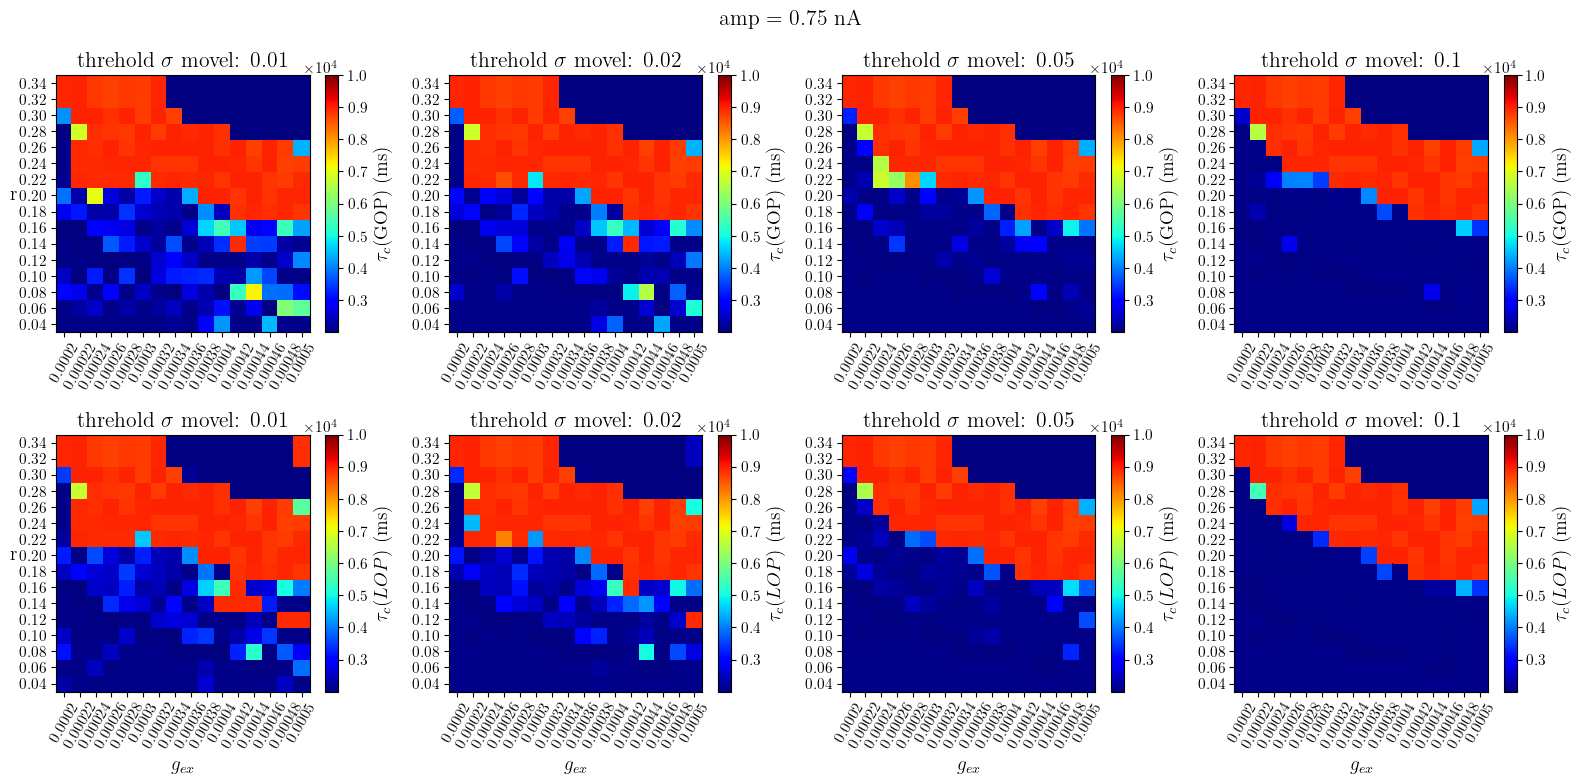

In [5]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(16,8))
fig.set_tight_layout(20)
i_inj = f'${axis_amp[0]}$'
fig.suptitle(f'amp = {i_inj} nA')
for ax0 in ax:
    for ax1 in ax0:
        # ax1.set_xlim(axis_gex[0]-5e-4, axis_gex[-1]+4e-4)
        # ax1.set_ylim(axis_raios[0]-1e-2, axis_raios[-1]+1e-2)
        ax1.set_yticks(axis_raios)
        ax1.set_xticks(axis_gex)
        ax1.set_xticklabels(axis_gex, rotation=60)

ax[0][0].set_title(f'threhold $\sigma$ movel: {std_thresholds[0]}')
tg, ig = np.meshgrid(axis_raios, axis_gex)
hm0 = ax[0][0].pcolor(ig, tg, tau_conv_gop_005_arr, cmap='jet', vmax=10000)
cbar0 = fig.colorbar(hm0, ax=ax[0][0])#, cax=cax1, format=formater)
cbar0.set_label(r'$\tau_c$(GOP) (ms)')

ax[0][1].set_title(f'threhold $\sigma$ movel: {std_thresholds[1]}')
tg, ig = np.meshgrid(axis_raios, axis_gex)
hm1 = ax[0][1].pcolor(ig, tg, tau_conv_gop_010_arr, cmap='jet', vmax=10000)
cbar1 = fig.colorbar(hm1, ax=ax[0][1])#, cax=cax1, format=formater)
cbar1.set_label(r'$\tau_c$(GOP) (ms)')

ax[0][2].set_title(f'threhold $\sigma$ movel: {std_thresholds[2]}')
tg, ig = np.meshgrid(axis_raios, axis_gex)
hm3 = ax[0][2].pcolor(ig, tg, tau_conv_gop_015_arr, cmap='jet', vmax=10000)
cbar3 = fig.colorbar(hm3, ax=ax[0][2])#, cax=cax1, format=formater)
cbar3.set_label(r'$\tau_c$(GOP) (ms)')

ax[0][3].set_title(f'threhold $\sigma$ movel: {std_thresholds[3]}')
tg, ig = np.meshgrid(axis_raios, axis_gex)
hm3 = ax[0][3].pcolor(ig, tg, tau_conv_gop_020_arr, cmap='jet', vmax=10000)
cbar3 = fig.colorbar(hm3, ax=ax[0][3])#, cax=cax1, format=formater)
cbar3.set_label(r'$\tau_c$(GOP) (ms)')

ax[1][0].set_title(f'threhold $\sigma$ movel: {std_thresholds[0]}')
tg, ig = np.meshgrid(axis_raios, axis_gex)
hm2 = ax[1][0].pcolor(ig, tg, tau_conv_lop_005_arr, cmap='jet', vmax=10000)
cbar2 = fig.colorbar(hm2, ax=ax[1][0])#, cax=cax1, format=formater)
cbar2.set_label(r'$\tau_c(LOP)$ (ms)')

ax[1][1].set_title(f'threhold $\sigma$ movel: {std_thresholds[1]}')
tg, ig = np.meshgrid(axis_raios, axis_gex)
hm2 = ax[1][1].pcolor(ig, tg, tau_conv_lop_010_arr, cmap='jet', vmax=10000)
cbar2 = fig.colorbar(hm2, ax=ax[1][1])#, cax=cax1, format=formater)
cbar2.set_label(r'$\tau_c(LOP)$ (ms)')

ax[1][2].set_title(f'threhold $\sigma$ movel: {std_thresholds[2]}')
tg, ig = np.meshgrid(axis_raios, axis_gex)
hm3 = ax[1][2].pcolor(ig, tg, tau_conv_lop_015_arr, cmap='jet', vmax=10000)
cbar3 = fig.colorbar(hm3, ax=ax[1][2])#, cax=cax1, format=formater)
cbar3.set_label(r'$\tau_c(LOP)$ (ms)')

ax[1][3].set_title(f'threhold $\sigma$ movel: {std_thresholds[3]}')
tg, ig = np.meshgrid(axis_raios, axis_gex)
hm3 = ax[1][3].pcolor(ig, tg, tau_conv_lop_020_arr, cmap='jet', vmax=10000)
cbar3 = fig.colorbar(hm3, ax=ax[1][3])#, cax=cax1, format=formater)
cbar3.set_label(r'$\tau_c(LOP)$ (ms)')



# label_tconvergencia_lop = r'$\sigma(\overline{LOP}) < 0.01$'
# label_tconvergencia_gop = r'$\sigma(GOP) < 0.01$'
# label_tconvergencia = r' GOP $ > 0.9 $'
# ax[0][0].set_title('Parâmetro Ordem Global')
# ax[0][1].set_title('Parâmetro Ordem Local($\delta = 5$)')
# ax[0][2].set_title('Frequência sPY')
# ax[1][0].set_title('Tempo de Convergência: '+label_tconvergencia_gop, fontsize=10, loc='left')
# ax[1][1].set_title('Tempo de Convergência: '+label_tconvergencia_lop, fontsize=10, loc='left')
# ax[1][2].set_title('Tempo de Convergência: ' + label_tconvergencia, fontsize=11, loc='left')

ax[0][0].set_ylabel('r ', rotation=0)
ax[1][0].set_ylabel('r ', rotation=0)
ax[1][0].set_xlabel('$g_{ex}$')
ax[1][1].set_xlabel('$g_{ex}$')
ax[1][2].set_xlabel('$g_{ex}$')
ax[1][3].set_xlabel('$g_{ex}$')
plt.savefig('../figures2/threshold_tempo_convergencia.png', dpi=600, bbox_inches='tight')
plt.show()

Text(0.5, 0, 't (ms)')

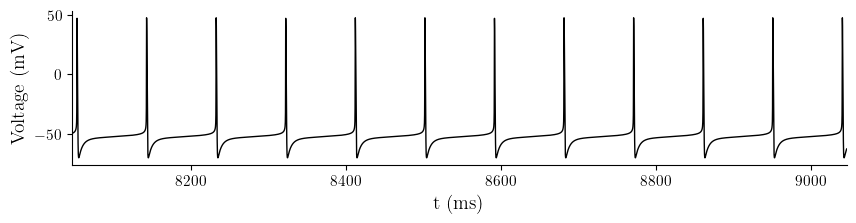

In [177]:
fig, ax = plt.subplots(figsize=(10,2))

times, vsomas = get_numpy(coerente, ti=60000, tf = 70000)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(times[0], times[-1])
ax.plot(times, vsomas[0, :], color='black')
ax.set_ylabel('Voltage (mV)')
ax.set_xlabel('t (ms)')